## Basic initialization

`SparkSession` is used to connect to the Spark Cluster.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import findspark
import pyspark.sql.functions as fn

We will use Pandas to operate on the reduced data in the *driver program*.

In [2]:
import pandas as pd

Numpy will be always useful.

In [3]:
import numpy as np

Create a new session (or reuse an existing one).

In [4]:
findspark.init()
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

# birth and death rate

Plot values of Birthrate and Deathrate against GDP per capita for the 30 richest and 30 poorest countries

In [6]:
countries = spark.read.csv("countries of the world.csv",inferSchema=True,header=True).cache()

In [7]:
countries.toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [8]:
from pyspark.sql.types import FloatType

def to_float (s) :
   return float(s.replace(',','.'))

float_udf = udf(to_float , FloatType())

In [9]:
full_countries = countries.select('Country', 'GDP ($ per capita)', 'Birthrate', 'Deathrate').na.drop()
full_countries = full_countries.withColumn("Birthrate", float_udf("Birthrate"))
full_countries = full_countries.withColumn("Deathrate", float_udf("Deathrate"))
full_countries.createOrReplaceTempView("full_countries")

In [10]:
full_countries.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             223 non-null    object 
 1   GDP ($ per capita)  223 non-null    int32  
 2   Birthrate           223 non-null    float32
 3   Deathrate           223 non-null    float32
dtypes: float32(2), int32(1), object(1)
memory usage: 4.5+ KB


In [11]:
query_birth = """FROM full_countries 
                SELECT `GDP ($ per capita)`, Birthrate 
                ORDER BY `GDP ($ per capita)` 
                LIMIT 30 
                
                UNION 
                
                FROM full_countries 
                SELECT `GDP ($ per capita)`, Birthrate 
                ORDER BY `GDP ($ per capita)` DESC
                LIMIT 30"""

query_death = """FROM full_countries 
                SELECT `GDP ($ per capita)`, Deathrate 
                ORDER BY `GDP ($ per capita)` 
                LIMIT 30 
                
                UNION 
                
                FROM full_countries 
                SELECT `GDP ($ per capita)`, Deathrate 
                ORDER BY `GDP ($ per capita)` DESC
                LIMIT 30"""

birth_rates = spark.sql(query_birth)
death_rates = spark.sql(query_death)

<Axes: xlabel='GDP ($ per capita)', ylabel='Birthrate'>

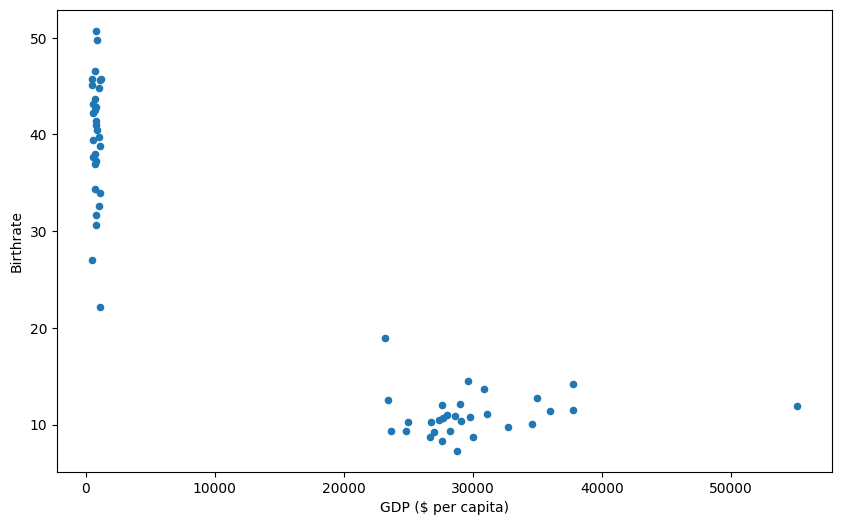

In [12]:
birth_rates.toPandas().plot(x="GDP ($ per capita)",y="Birthrate",kind="scatter",figsize=(10, 6))

<Axes: xlabel='GDP ($ per capita)', ylabel='Deathrate'>

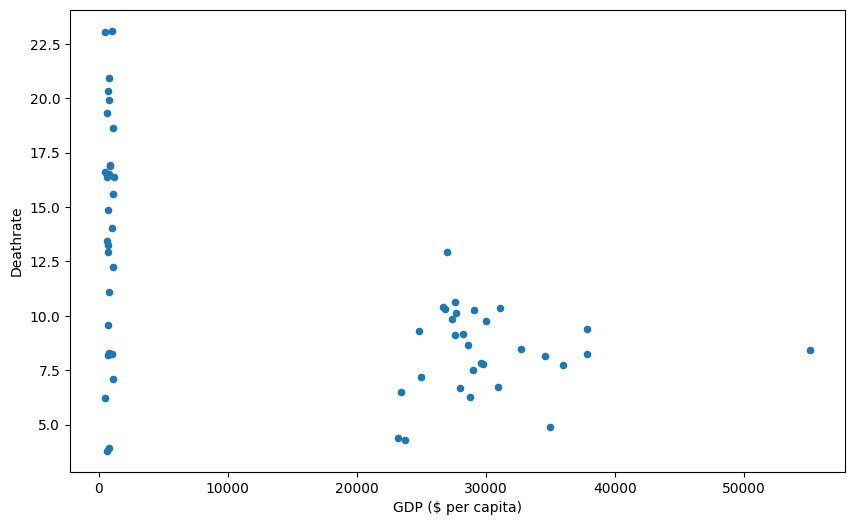

In [13]:
death_rates.toPandas().plot(x="GDP ($ per capita)",y="Deathrate",kind="scatter",figsize=(10, 6))

### Airport locations

In [14]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

columns = ["id", "name", "city", "country", "IATA", "ICAO", "latitude", "longitude", "altitude(ft)", "timezone_offset", "DST", "tz_olson_format", "airport_type", "data_source"]

airports = spark.read.csv("airports.csv").toDF(*columns)
airports = airports.withColumn("latitude", col("latitude").cast(FloatType()))
airports = airports.withColumn("longitude", col("longitude").cast(FloatType()))
airports = airports.withColumn("altitude(ft)", col("altitude(ft)").cast(IntegerType()))

airports.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7184 entries, 0 to 7183
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7184 non-null   object 
 1   name             7184 non-null   object 
 2   city             7140 non-null   object 
 3   country          7184 non-null   object 
 4   IATA             7183 non-null   object 
 5   ICAO             7184 non-null   object 
 6   latitude         7184 non-null   float32
 7   longitude        7184 non-null   float32
 8   altitude(ft)     7184 non-null   int32  
 9   timezone_offset  7184 non-null   object 
 10  DST              7184 non-null   object 
 11  tz_olson_format  7184 non-null   object 
 12  airport_type     7184 non-null   object 
 13  data_source      7184 non-null   object 
dtypes: float32(2), int32(1), object(11)
memory usage: 701.7+ KB


In [15]:
lat_long = airports.select("Latitude", "Longitude").toPandas()

lat = lat_long["Latitude"].values
long = lat_long["Longitude"].values

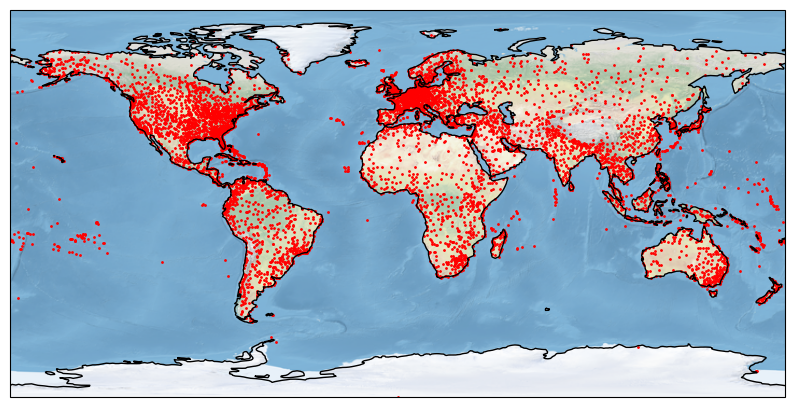

In [16]:
import cartopy.crs as crs
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()

plt.scatter(
    x=long,
    y=lat,
    color="r",
    s=1,
    transform=crs.PlateCarree(),
)

plt.show()

# Highest minimal altitude

In [17]:
from pyspark.sql.functions import min, desc

In [18]:
airports_min = (airports
                .select("country", "altitude(ft)")
                .groupBy("country")
                .agg(min("altitude(ft)")
                     .alias("altitude(ft)"))
                .orderBy(desc("altitude(ft)")))

meter_udf = udf(lambda x: x*0.3048, FloatType())

airports_min = airports_min.withColumn("altitude(m)",meter_udf("altitude(ft)"))

In [19]:
airports_min.show(10)

+-----------+------------+-----------+
|    country|altitude(ft)|altitude(m)|
+-----------+------------+-----------+
|    Lesotho|        5105|   1556.004|
|     Rwanda|        4859|  1481.0232|
|    Burundi|        2582|   786.9936|
|  West Bank|        2485|    757.428|
|     Uganda|        2472|   753.4656|
|  Swaziland|        2075|     632.46|
| Kyrgyzstan|        2058|   627.2784|
|   Botswana|        1772|   540.1056|
|     Malawi|        1580|    481.584|
|South Sudan|        1513|   461.1624|
+-----------+------------+-----------+
only showing top 10 rows



# number of airports against area

In [20]:
from pyspark.sql.functions import count
from pyspark.sql.types import StringType

In [21]:
map = {
        "AFRICA": "Africa",
        "AUSTRALIA" : "Australia/Oceania",
        "ASIA": "Asia",
        "BALTICS": "Europe",
        "EUROPE": "Europe",
        "IND": "Asia",
        "LATIN": "South America",
        "NEAR EAST": "Africa",
        "NORTHERN AMERICA": "North America",
        "OCEANIA": "Australia/Oceania",
        
    }

def region_mapping(s):
    for key, val in map.items():
        if key in s:
            return val
    return "Other"

continent_udf = udf(region_mapping,StringType())

In [22]:
import regex as re

def cleaenup_country(s):
    s = s.strip()
    s = re.sub(r"&", "and", s)
    s = re.sub(r", The", "", s)
    s = re.sub(r"Congo.*|Congo.*", "Congo", s)
    s = re.sub(r"Korea, North", "North Korea", s)
    s = re.sub(r"Korea, South", "South Korea", s)
    s = re.sub(r"Is\.", "Island", s)
    s = re.sub(r"Islands|Is(\s+|$)", "Island", s)
    s = re.sub(r"Micronesia.*", "Micronesia", s)
    s = re.sub(r"\(.*\)", "", s)
    s = re.sub(r" +", " ", s)
    
    return s

country_udf = udf(cleaenup_country,StringType())

In [23]:
countries_area = countries.select(country_udf("Country").alias("Country"), continent_udf("Region").alias("Continent"), "`Area (sq. mi.)`")

airports_countries = (airports
                      .select(country_udf("country").alias("Country"))
                      .groupBy("Country")
                      .agg(count("Country")
                           .alias("Count"))
                      .orderBy("Country"))

In [24]:
countries_area_airports = (
    countries_area
    .join(airports_countries, on="Country", how="inner")
    .orderBy("`Area (sq. mi.)`")
)

In [25]:
countries_area_airports.show()

+--------------------+-----------------+--------------+-----+
|             Country|        Continent|Area (sq. mi.)|Count|
+--------------------+-----------------+--------------+-----+
|           Gibraltar|           Europe|             7|    1|
|               Nauru|Australia/Oceania|            21|    1|
|              Tuvalu|Australia/Oceania|            26|    1|
|               Macau|             Asia|            28|    1|
|             Bermuda|    North America|            53|    1|
|            Guernsey|           Europe|            78|    2|
|          Montserrat|    South America|           102|    1|
|            Anguilla|    South America|           102|    1|
|              Jersey|           Europe|           116|    1|
|British Virgin Is...|    South America|           153|    3|
|               Aruba|    South America|           193|    1|
|      American Samoa|Australia/Oceania|           199|    2|
|         Cook Island|Australia/Oceania|           240|    8|
|Saint K

Plotting on logarythimc scale

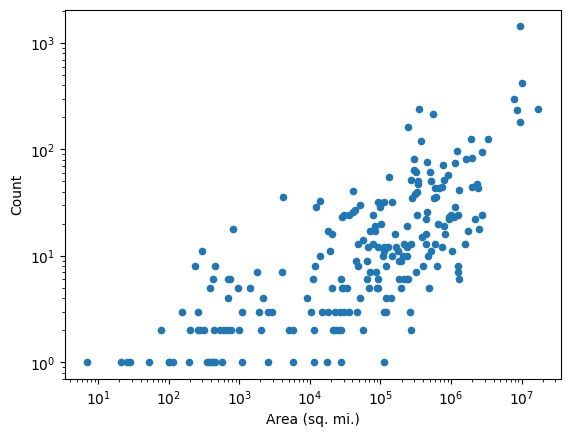

In [26]:
(countries_area_airports
 .select("`Area (sq. mi.)`", "Count")
 .toPandas()
 .plot(x="Area (sq. mi.)",y="Count",kind="scatter", logx=True, logy=True))
plt.show()

# Plot airports per continent

<Axes: ylabel='Count'>

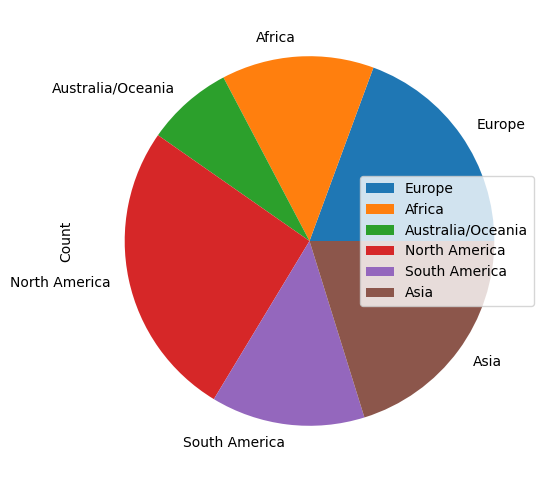

In [27]:
(countries_area_airports
 .groupBy(col("Continent"))
 .agg(fn.sum("Count")
      .alias("Count"))
 .select("Continent","Count")
 .toPandas()
 .set_index("Continent")
 .plot
 .pie(y="Count",x="Continent",figsize=(6, 6)))